<a href="https://colab.research.google.com/github/oussamaJMAA/Identification-of-the-most-relevant-CVs-for-tenders/blob/main/cv_tender_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: Identifying Relevant CVs for Tenders

In this Jupyter Notebook, I present a case study on identifying the most relevant CVs for tenders. My approach involves the following steps:

1. **Data Collection:**
   - I collected two datasets containing textual data about job descriptions and resumes.

2. **Data Integration and Exploration:**
   - I combined these datasets and perform data cleaning and visualization to gain insights into the data.

3. **Doc2Vec Model Training:**
   - I employed a Doc2Vec model, a popular technique for generating word embeddings, to capture the semantic meaning of the job descriptions and resumes.

4. **Vocabulary Enhancement:**
   - To enhance the model's vocabulary, I augmented it with additional data related to tenders and CVs.

5. **Model Training on Enriched Dataset:**
   - By training the Doc2Vec model on this enriched dataset, I created a word embedding model that possesses knowledge about tenders and CVs.

6. **Cosine Similarity Calculation:**
   - Utilizing the trained Doc2Vec model, I leveraged the power of word embeddings to generate embeddings for both CVs and tenders.
   - I computed the cosine similarity between the resulting vectors, a metric that quantifies the similarity between two vectors based on their orientation.

7. **Matching Process:**
   - By calculating the cosine similarity, I can determine the closest CV to the recruiter for a particular tender.

8. **Benefits:**
   - By employing this methodology, I provide recruiters with a data-driven approach to identify the most relevant CVs for tenders.
   - The use of word embeddings and cosine similarity allows for a more accurate and efficient matching process, ultimately saving time and resources in the recruitment process.



In [ ]:
# #Required libraries
# !pip install numpy
# !pip install pandas
# !pip install PyMuPDF
# !pip install gensim
# !pip install nltk
# !pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 50.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import fitz
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Data Preparation
The first dataset contain current job postings available on the City of New York’s official jobs site in 2020.  [New York Job Posting Dataset](https://data.world/city-of-ny/kpav-sd4t)
  
  The second dataset contain resumes with their corresponding categories , it was taken from kaggle [ResumeDataset](https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load new york job posting dataset
df = pd.read_csv('/content/drive/My Drive/DATASET/nyc-jobs-1.csv')
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,,,...,"Salary range for this position is: $42,405 - $...",,,,NaN,New York City residency is generally required ...,2011-06-24T00:00:00,NaN,2011-06-24T00:00:00,2018-07-17T00:00:00
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,,F,...,,"In addition to applying through this website, ...",,,NaN,New York City residency is generally required ...,2012-01-26T00:00:00,NaN,2012-01-26T00:00:00,2018-07-17T00:00:00
2,102221,DEPT OF ENVIRONMENT PROTECTION,External,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
3,102221,DEPT OF ENVIRONMENT PROTECTION,Internal,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
4,114352,DEPT OF ENVIRONMENT PROTECTION,Internal,5,Deputy Plant Chief,SENIOR STATIONARY ENGINEER (EL,91639,0,,F,...,Appointments are subject to OMB approval Fo...,"Click ""Apply Now"" button",40 per week / day,Various,NaN,New York City residency is generally required ...,2012-12-12T00:00:00,NaN,2012-12-13T00:00:00,2018-07-17T00:00:00


In [ ]:
df.shape

(3420, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3420 entries, 0 to 3419
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Business Title             3420 non-null   object
 1   Job Description            3420 non-null   object
 2   Minimum Qual Requirements  3408 non-null   object
 3   Preferred Skills           3420 non-null   object
dtypes: object(4)
memory usage: 107.0+ KB


In [ ]:
df.describe()

,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills
count,3420,3420,3408,3420
unique,1437,1743,436,1339
top,ANALYST,Budget Directors Office,1. A baccalaureate degree from an accredited c...,
freq,40,16,243,379


In [ ]:
# we keep only the relevant features
df =df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']]
df.head()

,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills
0,Account Manager,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...
1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,
2,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
3,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
4,Deputy Plant Chief,"Under general direction, is in responsible cha...",1. Six years of full-time satisfactory experie...,


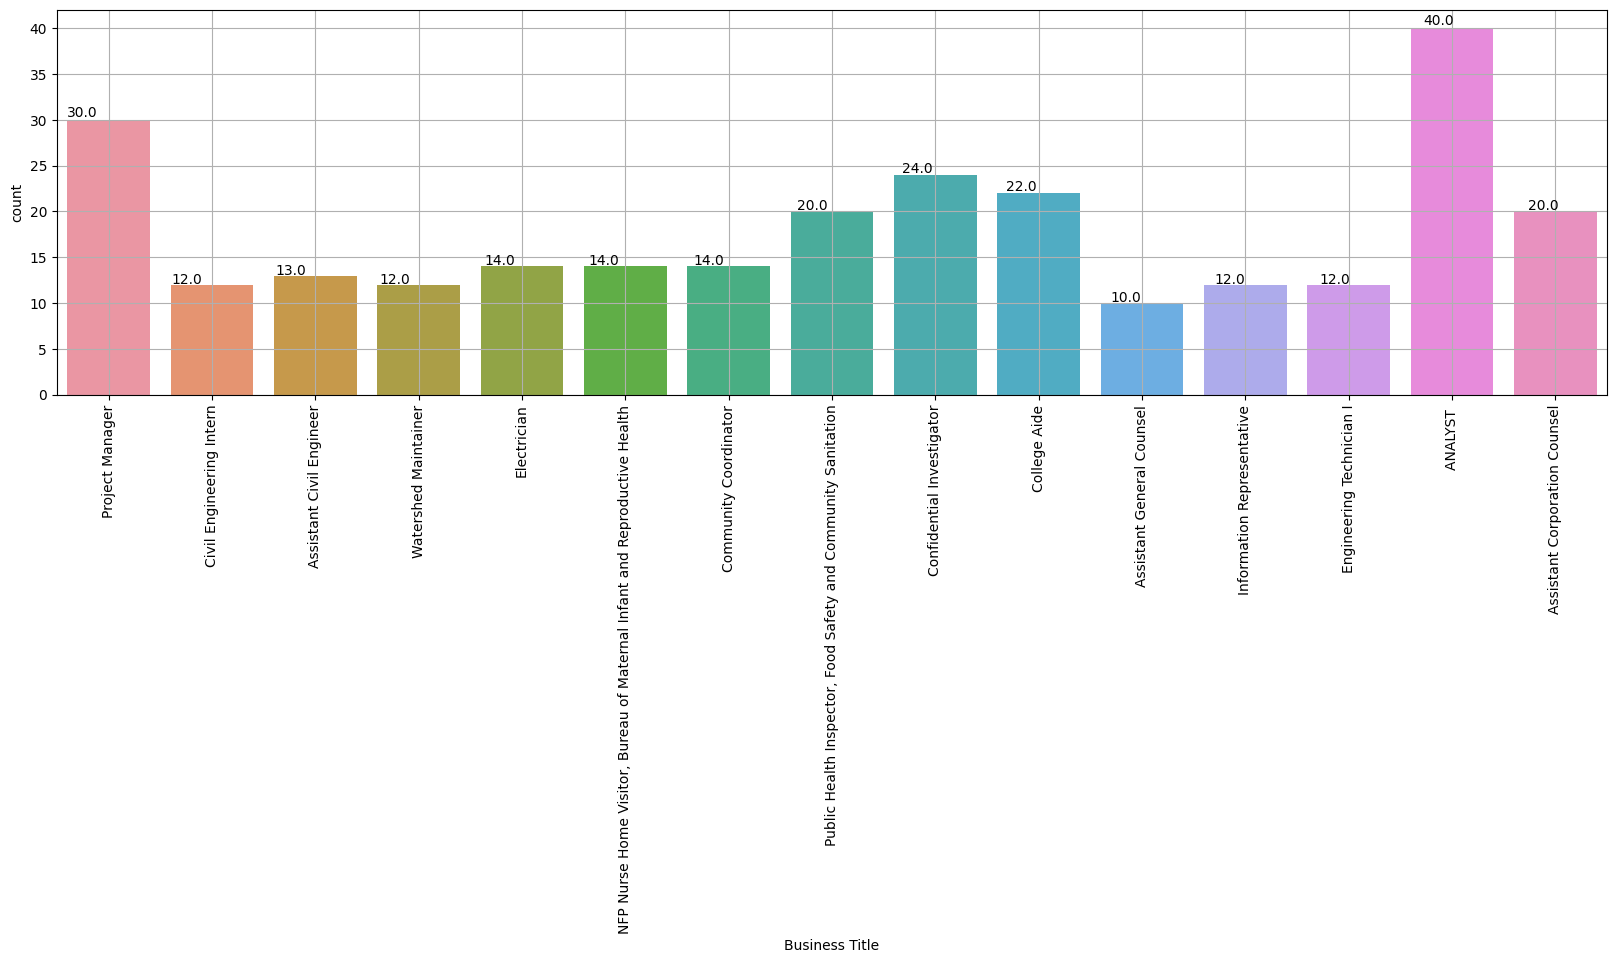

In [ ]:
top_categories = df['Business Title'].value_counts().nlargest(15).index

# Filter the DataFrame to include only the top 10 categories
df_top10 = df[df['Business Title'].isin(top_categories)]

# Plotting the top 10 categories
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
ax = sns.countplot(x="Business Title", data=df_top10)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

plt.grid()
plt.show()


In [ ]:
# Load the resume dataset
rdf = pd.read_csv('/content/drive/My Drive/DATASET/UpdatedResumeDataSet.csv')
rdf.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


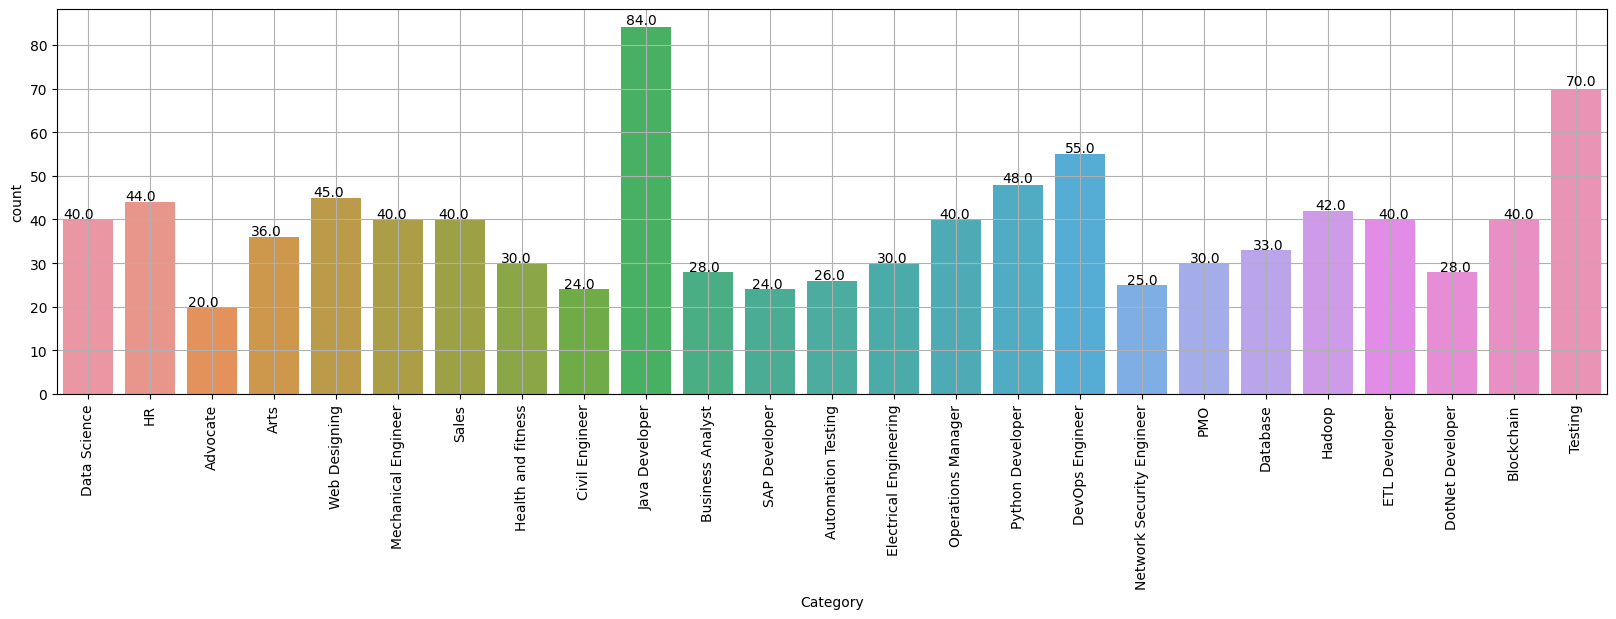

In [ ]:
#plotting the different categories
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=rdf)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

In [ ]:
#concatenate the two dataframes
df = pd.concat([df, pd.DataFrame({'Business Title': rdf["Category"], 'Job Description': rdf["Resume"]})], ignore_index=True)
df.shape

(4382, 4)

In [ ]:
# Creating a new column and merging the values of the other columns into it
df['data'] = df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# keeping only the data column since it contains the necessary information
df.drop(['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills'], axis=1, inplace=True)
df.head()

,data
0,Account Manager Division of Economic & Financi...
1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT The N..."
2,"Project Specialist Under direct supervision, p..."
3,"Project Specialist Under direct supervision, p..."
4,"Deputy Plant Chief Under general direction, is..."


In [ ]:
def clean_text(text):
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)

    # Remove numerical values from the text
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word.strip() for word in words if word not in stop_words]

    # Remove extra whitespaces
    text = ' '.join(words)

    return text

In [ ]:
#applying the cleaning
df['data'] = df['data'].apply(lambda x :clean_text(x))
df['data'][2]

'project specialist direct supervision perform elementary environmental engineering work field office laboratory receives training engineering work moderate difficulty responsibility assistant environmental engineer level work training may one following engineering areas development design drafting specifications estimating construction inspection operations maintenance prepares associated reports correspondence maintains records performs related work candidate review investigation remediation work plans reports evaluate interpret environmental data inspect remedial work activities schedule projects assist evaluating work performance position grant funded two year position ba alaureate degree redited college environmental chemical mechanical petroleum aeronautical materials engineering ba alaureate degree engineering technology eptable'

In [ ]:
#We tokenize the words and tag them with unique identifiers using the TaggedDocument class.
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(data)]

In [ ]:
# Model initialization
model = Doc2Vec(vector_size = 50,
min_count = 5,
epochs = 100,
alpha = 0.001
)
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

10658


In [ ]:
# Train the model
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)

model.save('/content/drive/My Drive/DATASET/cv_tender_matching.model')
print("Model saved")

Training epoch 1/100
Training epoch 2/100
Training epoch 3/100
Training epoch 4/100
Training epoch 5/100
Training epoch 6/100
Training epoch 7/100
Training epoch 8/100
Training epoch 9/100
Training epoch 10/100
Training epoch 11/100
Training epoch 12/100
Training epoch 13/100
Training epoch 14/100
Training epoch 15/100
Training epoch 16/100
Training epoch 17/100
Training epoch 18/100
Training epoch 19/100
Training epoch 20/100
Training epoch 21/100
Training epoch 22/100
Training epoch 23/100
Training epoch 24/100
Training epoch 25/100
Training epoch 26/100
Training epoch 27/100
Training epoch 28/100
Training epoch 29/100
Training epoch 30/100
Training epoch 31/100
Training epoch 32/100
Training epoch 33/100
Training epoch 34/100
Training epoch 35/100
Training epoch 36/100
Training epoch 37/100
Training epoch 38/100
Training epoch 39/100
Training epoch 40/100
Training epoch 41/100
Training epoch 42/100
Training epoch 43/100
Training epoch 44/100
Training epoch 45/100
Training epoch 46/1

### Testing the Model

In [ ]:
ds_job_description = """
Job Title: Data Scientist Intern

Location: [City, State]

Job Type: Internship

Company Overview:

[Company Name] is a dynamic and innovative [industry] company dedicated to [brief company description]. We are seeking a highly motivated and talented individual to join our data science team as a Data Scientist Intern. This internship provides an exciting opportunity to work on real-world projects, collaborate with experienced data scientists, and contribute to the success of our company.

Responsibilities:

Collaborate with cross-functional teams to understand business needs and define data science project objectives.
Clean, preprocess, and analyze large datasets to extract meaningful insights.
Develop and implement machine learning models for predictive and prescriptive analytics.
Utilize deep learning techniques to solve complex problems and enhance model performance.
Apply natural language processing (NLP) methods to extract insights from unstructured data sources.
Communicate findings to both technical and non-technical stakeholders through clear and compelling visualizations and reports.
Stay current with the latest advancements in data science, machine learning, and artificial intelligence.
Qualifications:

Currently pursuing a degree in Computer Science, Statistics, Mathematics, or a related field.
Strong programming skills in Python and experience with data manipulation libraries (e.g., pandas, NumPy).
Knowledge of machine learning algorithms and techniques, with a focus on supervised and unsupervised learning.
Familiarity with deep learning frameworks such as TensorFlow or PyTorch.
Understanding of natural language processing (NLP) concepts and applications.
Solid understanding of statistical concepts and methodologies.
Excellent problem-solving and analytical skills.
Effective communication and collaboration skills.
Additional Requirements:

Demonstrated interest and coursework in machine learning, deep learning, and NLP.
Prior internship or project experience in data science or related fields.
Strong attention to detail and a commitment to producing high-quality work.
Ability to work independently and in a team environment.
How to Apply:

Interested candidates should submit a resume, cover letter, and portfolio (if applicable) to [email@example.com] with the subject line "Data Scientist Intern Application - [Your Full Name]". Please include a brief description of your relevant coursework, projects, and why you are interested in joining our data science team.

[Company Name] is an equal opportunity employer. We encourage applications from candidates of all backgrounds and experiences.
"""

In [ ]:
def recommended_cv(CVs_list, tender, model):
    # Clean the job tender
    tender = clean_text(tender)

    # Calculate similarity scores for each CV
    similarity_scores = []
    for cv_text in CVs_list:
        cv_text = clean_text(cv_text)
        cv_vector = model.infer_vector(cv_text.split())
        tender_vector = model.infer_vector(tender.split())
        similarity = 100 * (np.dot(np.array(cv_vector), np.array(tender_vector))) / (norm(np.array(cv_vector)) * norm(np.array(tender_vector)))
        similarity_scores.append(similarity)

    # Get indices of the top 5 CVs
    top_5_indices = np.argsort(similarity_scores)[-5:][::-1]

    # Return the top 5 recommended CVs
    recommended_cv_list = []
    for index in top_5_indices:
        recommended_cv_list.append({
            "index": index + 1,
            "similarity": round(similarity_scores[index], 2),
            "cv_content": CVs_list[index]
        })

    return recommended_cv_list

In [ ]:
def extract_text_from_pdf(pdf_path, page_num):
    pdf_document = fitz.open(pdf_path)

    try:
        # Subtract 1 because page numbers are 1-based
        page = pdf_document[page_num - 1]
        extracted_text = page.get_text()
        return extracted_text
    finally:
        pdf_document.close()

In [ ]:
#testing with one CV :
pdf_path1 = "/content/Oussama Jmâa Cv (2).pdf"
page_number = 1
cv_ds = extract_text_from_pdf(pdf_path1, page_number)
cv_ds = clean_text(cv_ds)
ds_job_description = clean_text(ds_job_description)
# calculating the similarity score

model = Doc2Vec.load('/content/cv_tender_matching.model')
cv_vector = model.infer_vector(cv_ds.split())
tender_vector = model.infer_vector(ds_job_description.split())
similarity = 100*(np.dot(np.array(cv_vector), np.array(tender_vector))) / (norm(np.array(cv_vector)) * norm(np.array(tender_vector)))
print(f"the matching score for this cv is :  {round(similarity, 2)}")

the matching score for this cv is :  57.15


In [ ]:
# extracting text from pdfs
pdf_path1 = "/content/Oussama Jmâa Cv (2).pdf"
pdf_path2 = "/content/security_guard_CV_template.pdf"
pdf_path3 = "/content/web_cv.pdf"
pdf_path4 = "/content/ds_cv.pdf"
pdf_path5 = "/content/data_analyst_cv.pdf"
page_number = 1
cv_ds = extract_text_from_pdf(pdf_path1, page_number)
cv_ds2 = extract_text_from_pdf(pdf_path4, page_number)
cv_securiy_guard = extract_text_from_pdf(pdf_path2, page_number)
cv_web =  extract_text_from_pdf(pdf_path3, page_number)
cv_data_analyst =  extract_text_from_pdf(pdf_path5, page_number)

In [ ]:
#testing the model :

# Load the trained Doc2Vec model
model = Doc2Vec.load('/content/cv_tender_matching.model')


list_of_cvs = []
# List of CVs
list_of_cvs.extend([cv_ds,cv_web,cv_securiy_guard])

# Get the recommended CVs
recommended_CVs = recommended_cv(list_of_cvs, ds_job_description, model)

# Print the top 5 recommended CVs
print("Top 5 Recommended CVs:")
for cv in recommended_CVs:
    print(f"CV {cv['index']} - Similarity: {cv['similarity']}%")
    print('*'* 100)
    print(cv['cv_content'])
    print('*'* 100)
    print("\n")

Top 5 Recommended CVs:
CV 1 - Similarity: 57.15%
****************************************************************************************************
EDUCATION
ABOUT ME
PROJECTS
Ariana,Tunis
github.com/oussamaJMAA
www.linkedin.com/in/oussama-
jmaa-217098171/
jemaaoussama64@gmail.com
I am a final year Data Science student at Esprit School of
Engineering, actively seeking an end of stuides internship and
potential job opportunity. My passion for AI fuels my motivation to
learn new technologies and enhance my skills in this field.
Computer Science
ESPRIT , SCHOOL OF ENGINEERING
AND TECHNOLOGY
2019 - present
CONTACT
Collaborated with 2 students to develop a website that contains
quizzes, courses, recommendations for employees to test and
improve their knowledge in cyber security and networking.
Tools: HTML5, CSS3,PHP7.4,SYMFONY4.4, Python, BeautifulSoup,SQL
2021-2022
Employee evaluation Platform
University Project
In a team of six , i worked on a machine learning project with python
using 